<a href="https://colab.research.google.com/github/FilipposMoscholios/Deep-Learning-First-Assignment/blob/main/deep_learning_ass_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FASHION TIME RECOGNITION
**USING MLP AND CNN**

Authors:

**Andreadis Georgios**

**Moscholios Filippos - Michael**

## Import the libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.regularizers import l2
import scipy.stats as stats

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf

from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.utils import plot_model, model_to_dot

from tensorflow.keras import metrics
from tensorflow.random import set_seed
!pip install keras_tuner --upgrade
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the dataset

In [ ]:
# fashion_mnist = tf.keras.datasets.fashion_mnist
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("The shape of the train set is:", x_train.shape)
print("The shape of the test set is:", x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
The shape of the train set is: (60000, 28, 28)
The shape of the test set is: (10000, 28, 28)


In [ ]:
# add a fourth dimension (RGB)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Standardize each pixel for all images
x_train, x_test = x_train / 255.0, x_test / 255.0

## Data Preprocessing

In [ ]:
train_images = np.copy(x_train)
train_labels = np.copy(y_train)
test_images = np.copy(x_test)
test_labels = np.copy(y_test)

In [ ]:
train_images.shape, test_images.shape, train_labels.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,))

In [ ]:
train_images_count = x_train.shape[0]
test_images_count = x_test.shape[0]
image_size = x_train.shape[1]

In [ ]:
labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

def get_label(index: int):
    return labels.get(index, "undefined")

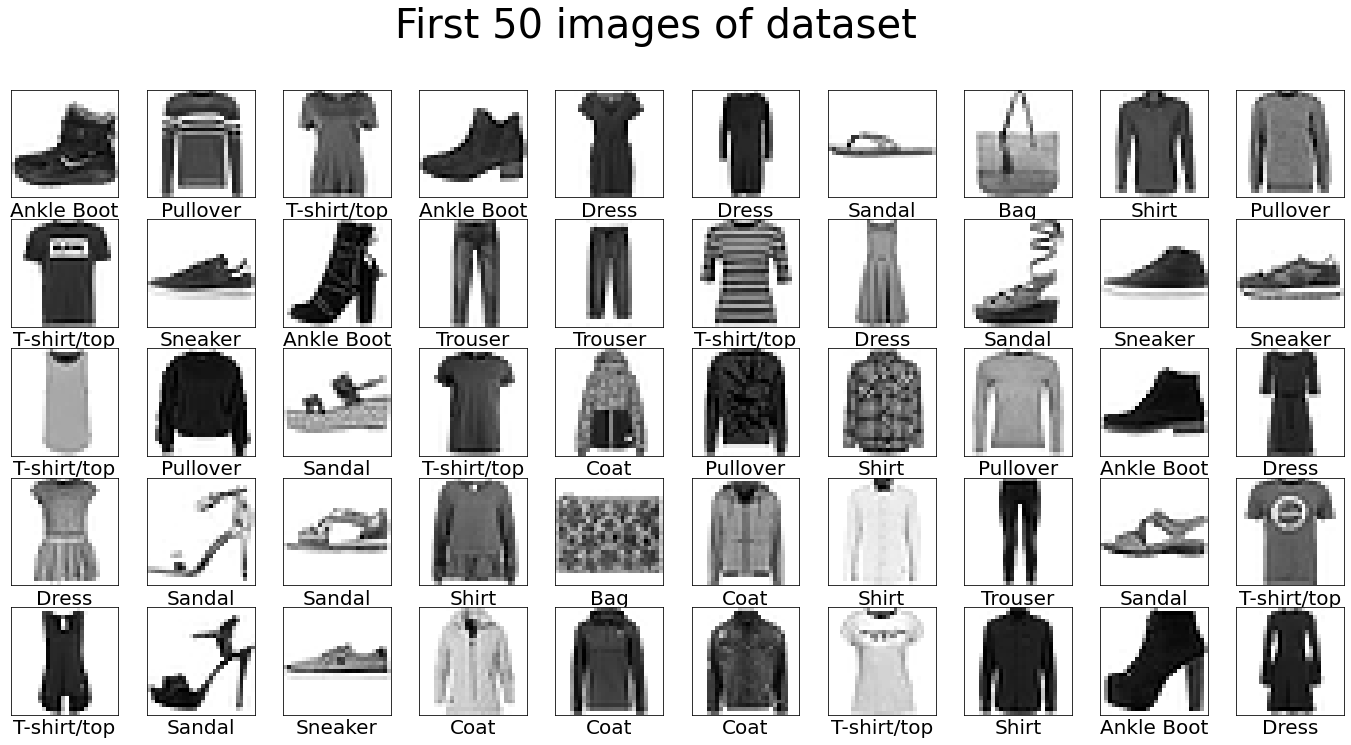

In [ ]:
fig, axes = plt.subplots(5, 10, figsize=(24, 11.5))

for i in range(0, 50):
    ax = axes[int(i%5), int(i/5)]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(train_images[i,:,:,0], cmap=plt.cm.binary)
    ax.set_xlabel(get_label(train_labels[i]), fontsize = 20)
plt.suptitle("First 50 images of dataset", fontsize = 40)
plt.show()

In [ ]:
class_labels = list(labels.values())
x = np.arange(len(class_labels))

In [ ]:
class_dist_train = pd.DataFrame(y_train, columns=["class"])
exploratory_train = class_dist_train['class'].groupby(class_dist_train["class"]).count()
class_dist_test = pd.DataFrame(y_test, columns=["class"])
exploratory_test = class_dist_test['class'].groupby(class_dist_test["class"]).count()
pd.DataFrame((list(exploratory_train), list(exploratory_test)))

d = dict(zip(x, [list(exploratory_train), list(exploratory_test)]))
d = pd.DataFrame.from_dict(d)
d.rename(columns = {0 : 'train', 1 : 'test'}, inplace = True)
d

,train,test
0,6000,1000
1,6000,1000
2,6000,1000
3,6000,1000
4,6000,1000
5,6000,1000
6,6000,1000
7,6000,1000
8,6000,1000
9,6000,1000


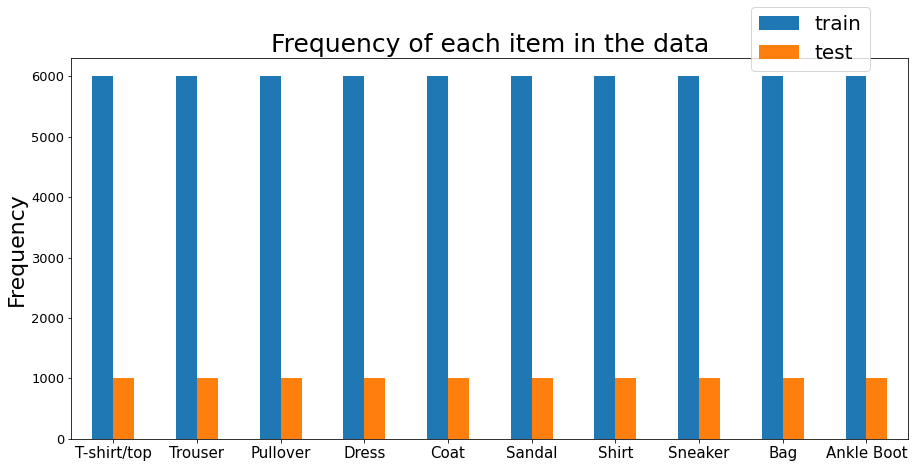

In [ ]:
d.plot.bar(figsize= (15,7))
plt.title("Frequency of each item in the data", fontsize = 25)
plt.ylabel("Frequency", fontsize = 22)
plt.xticks(x, class_labels, rotation = 'horizontal', fontsize = 15)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 20, bbox_to_anchor=(0.8, 0.94))
plt.show()

In [ ]:
# one hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

y_train[:2], y_test[0:2]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title = "Confusion Matrix"):

  """Plot the confusion matrix alongside with the metrics"""

  # take the metrics

  prec = precision_score(y_true, y_pred, average = None)
  rec = recall_score(y_true, y_pred, average = None)
  acc = accuracy_score(y_true, y_pred)
  f1_macro = f1_score(y_true, y_pred, average = 'macro')

  # plot the confusion matrix
  fig, ax = plt.subplots(figsize=(15,7))
  ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                 annot=True,
                 fmt='g',
                 cmap="Blues",
                 annot_kws={"fontsize":22},
                 cbar=False)

  ax.set_title(title, pad=15, fontsize=30)
  ax.set_xlabel('Predicted labels', labelpad=10, fontsize = 20)
  ax.set_ylabel("True labels", labelpad=5, fontsize=20)
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  ax.xaxis.set_ticklabels(list(labels.values()), fontsize = 17)
  ax.yaxis.set_ticklabels(list(labels.values()), rotation=0, fontsize = 17)

  # print the preicison scores
  plt.text(x = -1.5, y = 11, s = "Precision", fontsize=25, color = "blue")
  position_p = 0.1
  for i in range(10):

    if i == prec.argmax():
      c = "green"
    elif i == prec.argmin():
      c = "red"
    else:
      c = "black"

    plt.text(x = position_p + i, y = 11, s = f"{prec[i]*100:.2f}%", color = c, fontsize=17)


  # print the recall scores
  plt.text(x = 10.5, y = -0.4, s = "Recall", fontsize=25, color = "blue")
  position_r = 0.5
  for i in range(10):
    if i == rec.argmax():
      c = "green"
    elif i == rec.argmin():
      c = "red"
    else:
      c = "black"

    plt.text(x = 10.5, y = position_r + i, s = f"{rec[i]*100:.2f}%", color = c, fontsize=17)

  plt.text(x = 10.6, y = 11.1, s = f"Accuracy = {acc*100:.2f}%", color = "blue", fontsize=20)
  plt.text(x = 10.45, y = 11.6, s = f"f1 (macro) = {f1_macro*100:.2f}%", color = "blue", fontsize=20)


  plt.show()
  return

In [ ]:
# split the train data into train and validation
x_train_total = x_train
y_train_total = y_train
x_train, x_val, y_train, y_val = train_test_split(x_train_total,
                                                  y_train_total,
                                                  test_size = 0.1,
                                                  random_state = 32,
                                                  stratify = y_train_total)
# data for CNN
train_images_total = np.copy(x_train_total)
train_images = np.copy(x_train)
val_images = np.copy(x_val)

## MLP

In [ ]:
# reshape the images tf.reshape(x, [-1])
x_train_total = x_train_total.reshape((train_images_count, image_size * image_size,))
x_train = x_train.reshape((int(train_images_count*0.9), image_size * image_size,))
x_val = x_val.reshape((int(train_images_count*0.1), image_size * image_size,))
x_test = x_test.reshape((test_images_count, image_size * image_size,))

print(x_train.shape, x_val.shape, x_test.shape)

(54000, 784) (6000, 784) (10000, 784)


In [ ]:
def mlp_model(hp):

  input = Input(shape = (image_size**2,),
                name = "Input")
  x = input

  hp_layers = hp.Int('n_layers', min_value = 1, max_value = 3)

  for i in range(hp_layers):

    hp_units = hp.Choice(f'units_{i+1}', [1024, 512, 256])
    hp_regul = hp.Choice(f"alpha_{i+1}", [1e-2, 1e-3])

    x = Dense(units = hp_units,
              kernel_initializer='random_normal',
              kernel_regularizer=l2(hp_regul),
              activation = 'selu',
              name = f"Dense_{i+1}")(x)

    x = BatchNormalization(name = f"Normalization_{i+1}")(x)


    hp_rate = hp.Choice(f'rate_{i+1}', [0.1, 0.3])

    x = Dropout(rate = hp_rate,
                name = f"Dropout_{i+1}")(x)


  output = Dense(units = 10,
                 kernel_initializer='random_normal',
                 activation = "softmax",
                 name = "Output")(x)

  model = Model(inputs=input, outputs=output)

  hp_lr = hp.Choice('learning_rate', [1e-2, 1e-3])
  hp_mom = hp.Choice('momentum', [0.5, 0.9])
  model.compile(optimizer=SGD(learning_rate = hp_lr, momentum = hp_mom),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.BayesianOptimization(hypermodel = mlp_model,
                                objective = "val_accuracy",
                                max_trials = 30,
                                num_initial_points = 100,
                                alpha = 0.0001,
                                overwrite = True,
                                beta = 2.6,
                                seed = 32,
                                directory="drive/MyDrive/my_dir",
                                project_name="mlp_mnist")

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_1 (Choice)
{'default': 1024, 'conditions': [], 'values': [1024, 512, 256], 'ordered': True}
alpha_1 (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
rate_1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
momentum (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.9], 'ordered': True}


In [ ]:
# perform early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)

# perform scheduler
def scheduler(epoch, lr):
  if epoch <10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

sched = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# perform the tuning
tuner.search(x_train,
             y_train,
             epochs=40,
             validation_split =  (x_val, y_val),
             callbacks=[es],
             batch_size=512)


Trial 29 Complete [00h 00m 19s]
val_accuracy: 0.8506666421890259

Best val_accuracy So Far: 0.8773333430290222
Total elapsed time: 00h 59m 25s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
2                 |4                 |n_layers
0.001             |0.01              |learning_rate
0.9               |0.9               |momentum
512               |512               |units_0
0.01              |0.001             |alpha_0
0.3               |0.3               |rate_0
256               |128               |units_1
0.01              |0.001             |alpha_1
0.4               |0.6               |rate_out
0.3               |0.1               |rate_1
128               |128               |units_2
0.01              |0.001             |alpha_2
0.1               |0.3               |rate_2
256               |256               |units_3
0.01              |0.01              |alpha_3

Epoch 1/40
106/106 [==============================] - 6s 49ms/step - loss: 14.3

In [ ]:
tuner.results_summary()

Results summary
Results in drive/MyDrive/my_dir/mlp_mnist
Showing 10 best trials
Trial summary
Hyperparameters:
n_layers: 3
units_1: 512
alpha_1: 0.001
rate_1: 0.3
learning_rate: 0.01
momentum: 0.9
units_2: 1024
alpha_2: 0.001
rate_2: 0.3
units_3: 256
alpha_3: 0.001
rate_3: 0.3
Score: 0.8865000009536743
Trial summary
Hyperparameters:
n_layers: 3
units_1: 1024
alpha_1: 0.01
rate_1: 0.3
learning_rate: 0.01
momentum: 0.9
units_2: 1024
alpha_2: 0.001
rate_2: 0.1
units_3: 512
alpha_3: 0.01
rate_3: 0.1
Score: 0.8811666369438171
Trial summary
Hyperparameters:
n_layers: 2
units_1: 1024
alpha_1: 0.01
rate_1: 0.1
learning_rate: 0.01
momentum: 0.5
units_2: 256
alpha_2: 0.001
rate_2: 0.1
units_3: 512
alpha_3: 0.01
rate_3: 0.1
Score: 0.8803333044052124
Trial summary
Hyperparameters:
n_layers: 2
units_1: 1024
alpha_1: 0.001
rate_1: 0.3
learning_rate: 0.01
momentum: 0.9
units_2: 1024
alpha_2: 0.01
rate_2: 0.1
Score: 0.8798333406448364
Trial summary
Hyperparameters:
n_layers: 2
units_1: 512
alpha_1: 0

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Dense_1 (Dense)             (None, 512)               401920    
                                                                 
 Normalization_1 (BatchNorma  (None, 512)              2048      
 lization)                                                       
                                                                 
 Dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 Dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 Normalization_2 (BatchNorma  (None, 1024)             4096      
 lization)                                                 

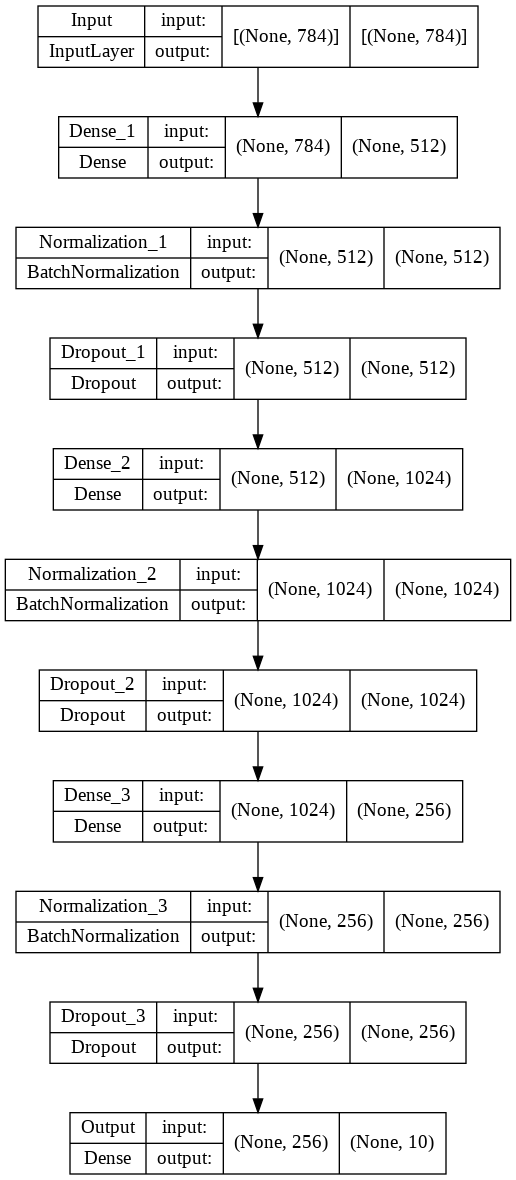

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# build the best model
model_mlp = tuner.hypermodel.build(best_hps)

model_mlp.summary()


In [ ]:
# perform scheduler
def scheduler(epoch, lr):
  if epoch <10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

sched = tf.keras.callbacks.LearningRateScheduler(scheduler)

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=13)

# Save model weights after each epoch with ModelCheckpoint
if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
  os.makedirs('/content/gdrive/My Drive/checkpoints')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/mlp.hdf5',
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)


In [ ]:
history = model_mlp.fit(x_train,
                        y_train,
                        epochs = 100,
                        validation_data = (x_val, y_val),
                        callbacks = [es, checkpoint, sched],
                        batch_size = 64)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))



Epoch 1/100
842/844 [============================>.] - ETA: 0s - loss: 3.1171 - accuracy: 0.7975
Epoch 1: val_accuracy improved from -inf to 0.82867, saving model to /content/gdrive/My Drive/checkpoints/mlp.hdf5
844/844 [==============================] - 24s 27ms/step - loss: 3.1161 - accuracy: 0.7975 - val_loss: 2.6378 - val_accuracy: 0.8287 - lr: 0.0100
Epoch 2/100
842/844 [============================>.] - ETA: 0s - loss: 2.3103 - accuracy: 0.8336
Epoch 2: val_accuracy improved from 0.82867 to 0.85783, saving model to /content/gdrive/My Drive/checkpoints/mlp.hdf5
844/844 [==============================] - 21s 25ms/step - loss: 2.3098 - accuracy: 0.8335 - val_loss: 1.9581 - val_accuracy: 0.8578 - lr: 0.0100
Epoch 3/100
843/844 [============================>.] - ETA: 0s - loss: 1.7728 - accuracy: 0.8451
Epoch 3: val_accuracy did not improve from 0.85783
844/844 [==============================] - 21s 25ms/step - loss: 1.7729 - accuracy: 0.8451 - val_loss: 1.5430 - val_accuracy: 0.8572 

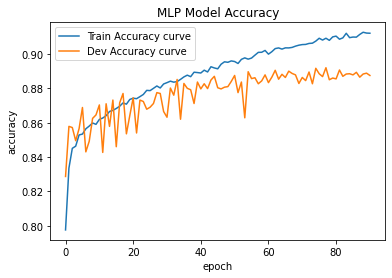

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy curve', 'Dev Accuracy curve'], loc='upper left')
plt.show()

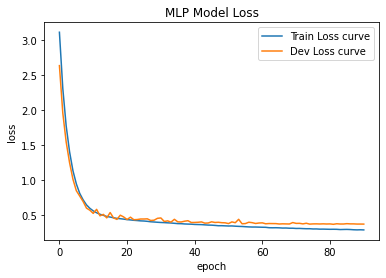

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss curve', 'Dev Loss curve'], loc='upper right')
plt.show()

In [ ]:
# save the model
model_mlp.save('/content/drive/MyDrive/mlp_pretrained')

In [ ]:
# load the model
pretrained_mlp = load_model("/content/drive/MyDrive/mlp_pretrained")

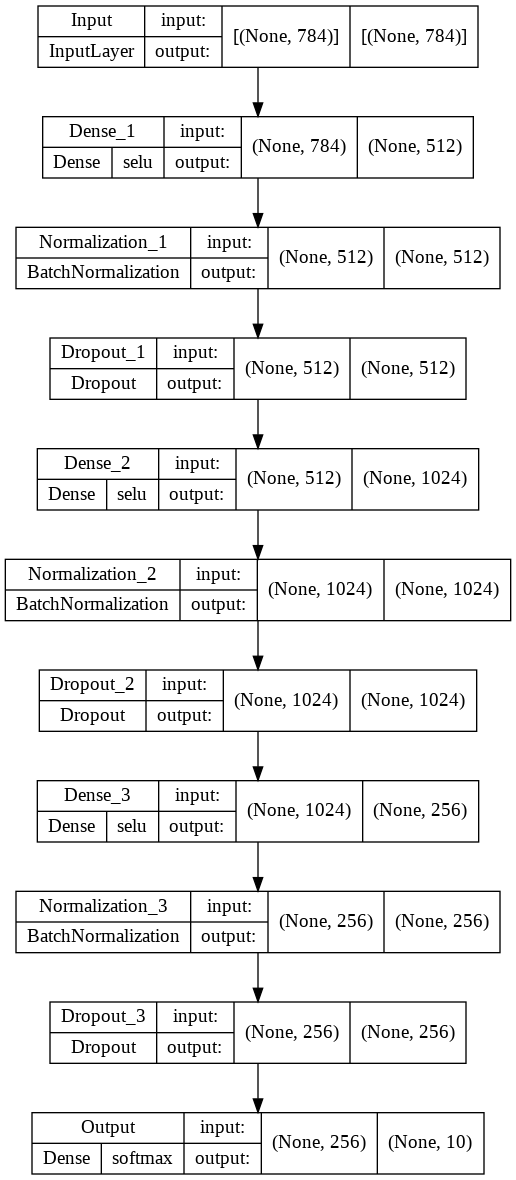

In [ ]:
plot_model(pretrained_mlp,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_activations = True,
           show_layer_names=True)

In [ ]:
model_mlp_eval = pretrained_mlp.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 3s 7ms/step - loss: 0.3865 - accuracy: 0.8811


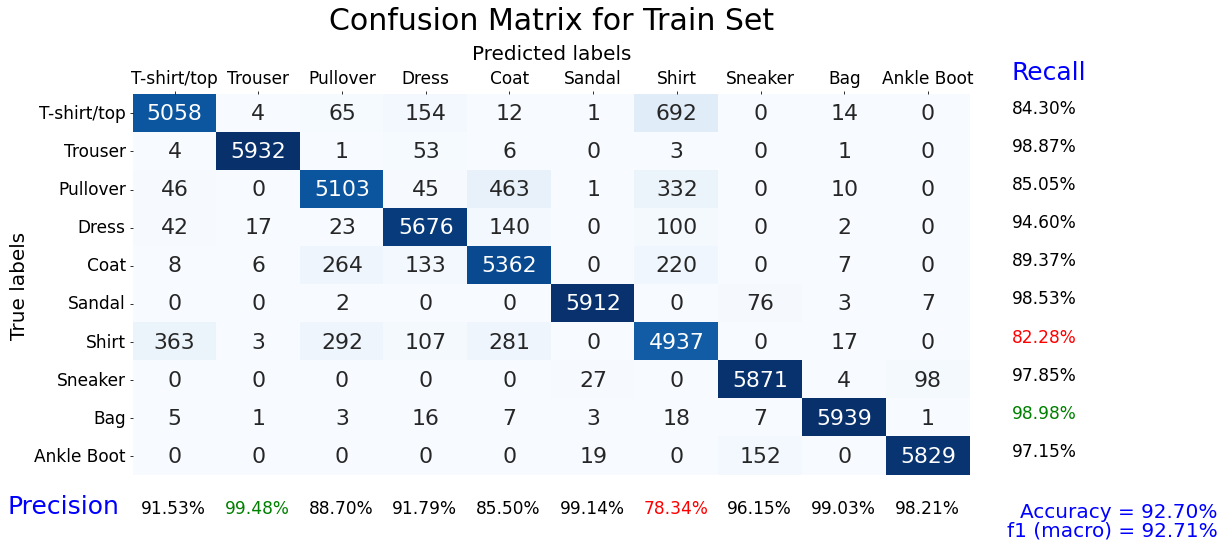

In [ ]:
predictions_prob = pretrained_mlp.predict(x_train_total)
y_pred_mlp_train = np.argmax(predictions_prob, axis = 1)
plot_confusion_matrix(train_labels, y_pred_mlp_train, title = "Confusion Matrix for Train Set")

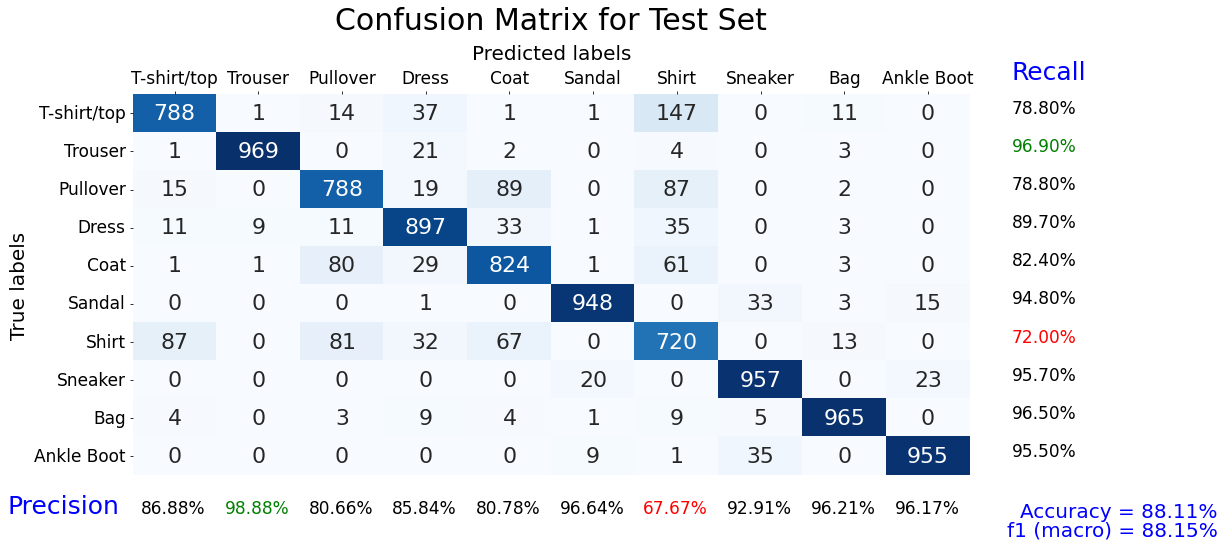

In [ ]:
predictions_prob_mlp = pretrained_mlp.predict(x_test)
y_pred_mlp_test = np.argmax(predictions_prob_mlp, axis = 1)
plot_confusion_matrix(test_labels, y_pred_mlp_test, title = "Confusion Matrix for Test Set")

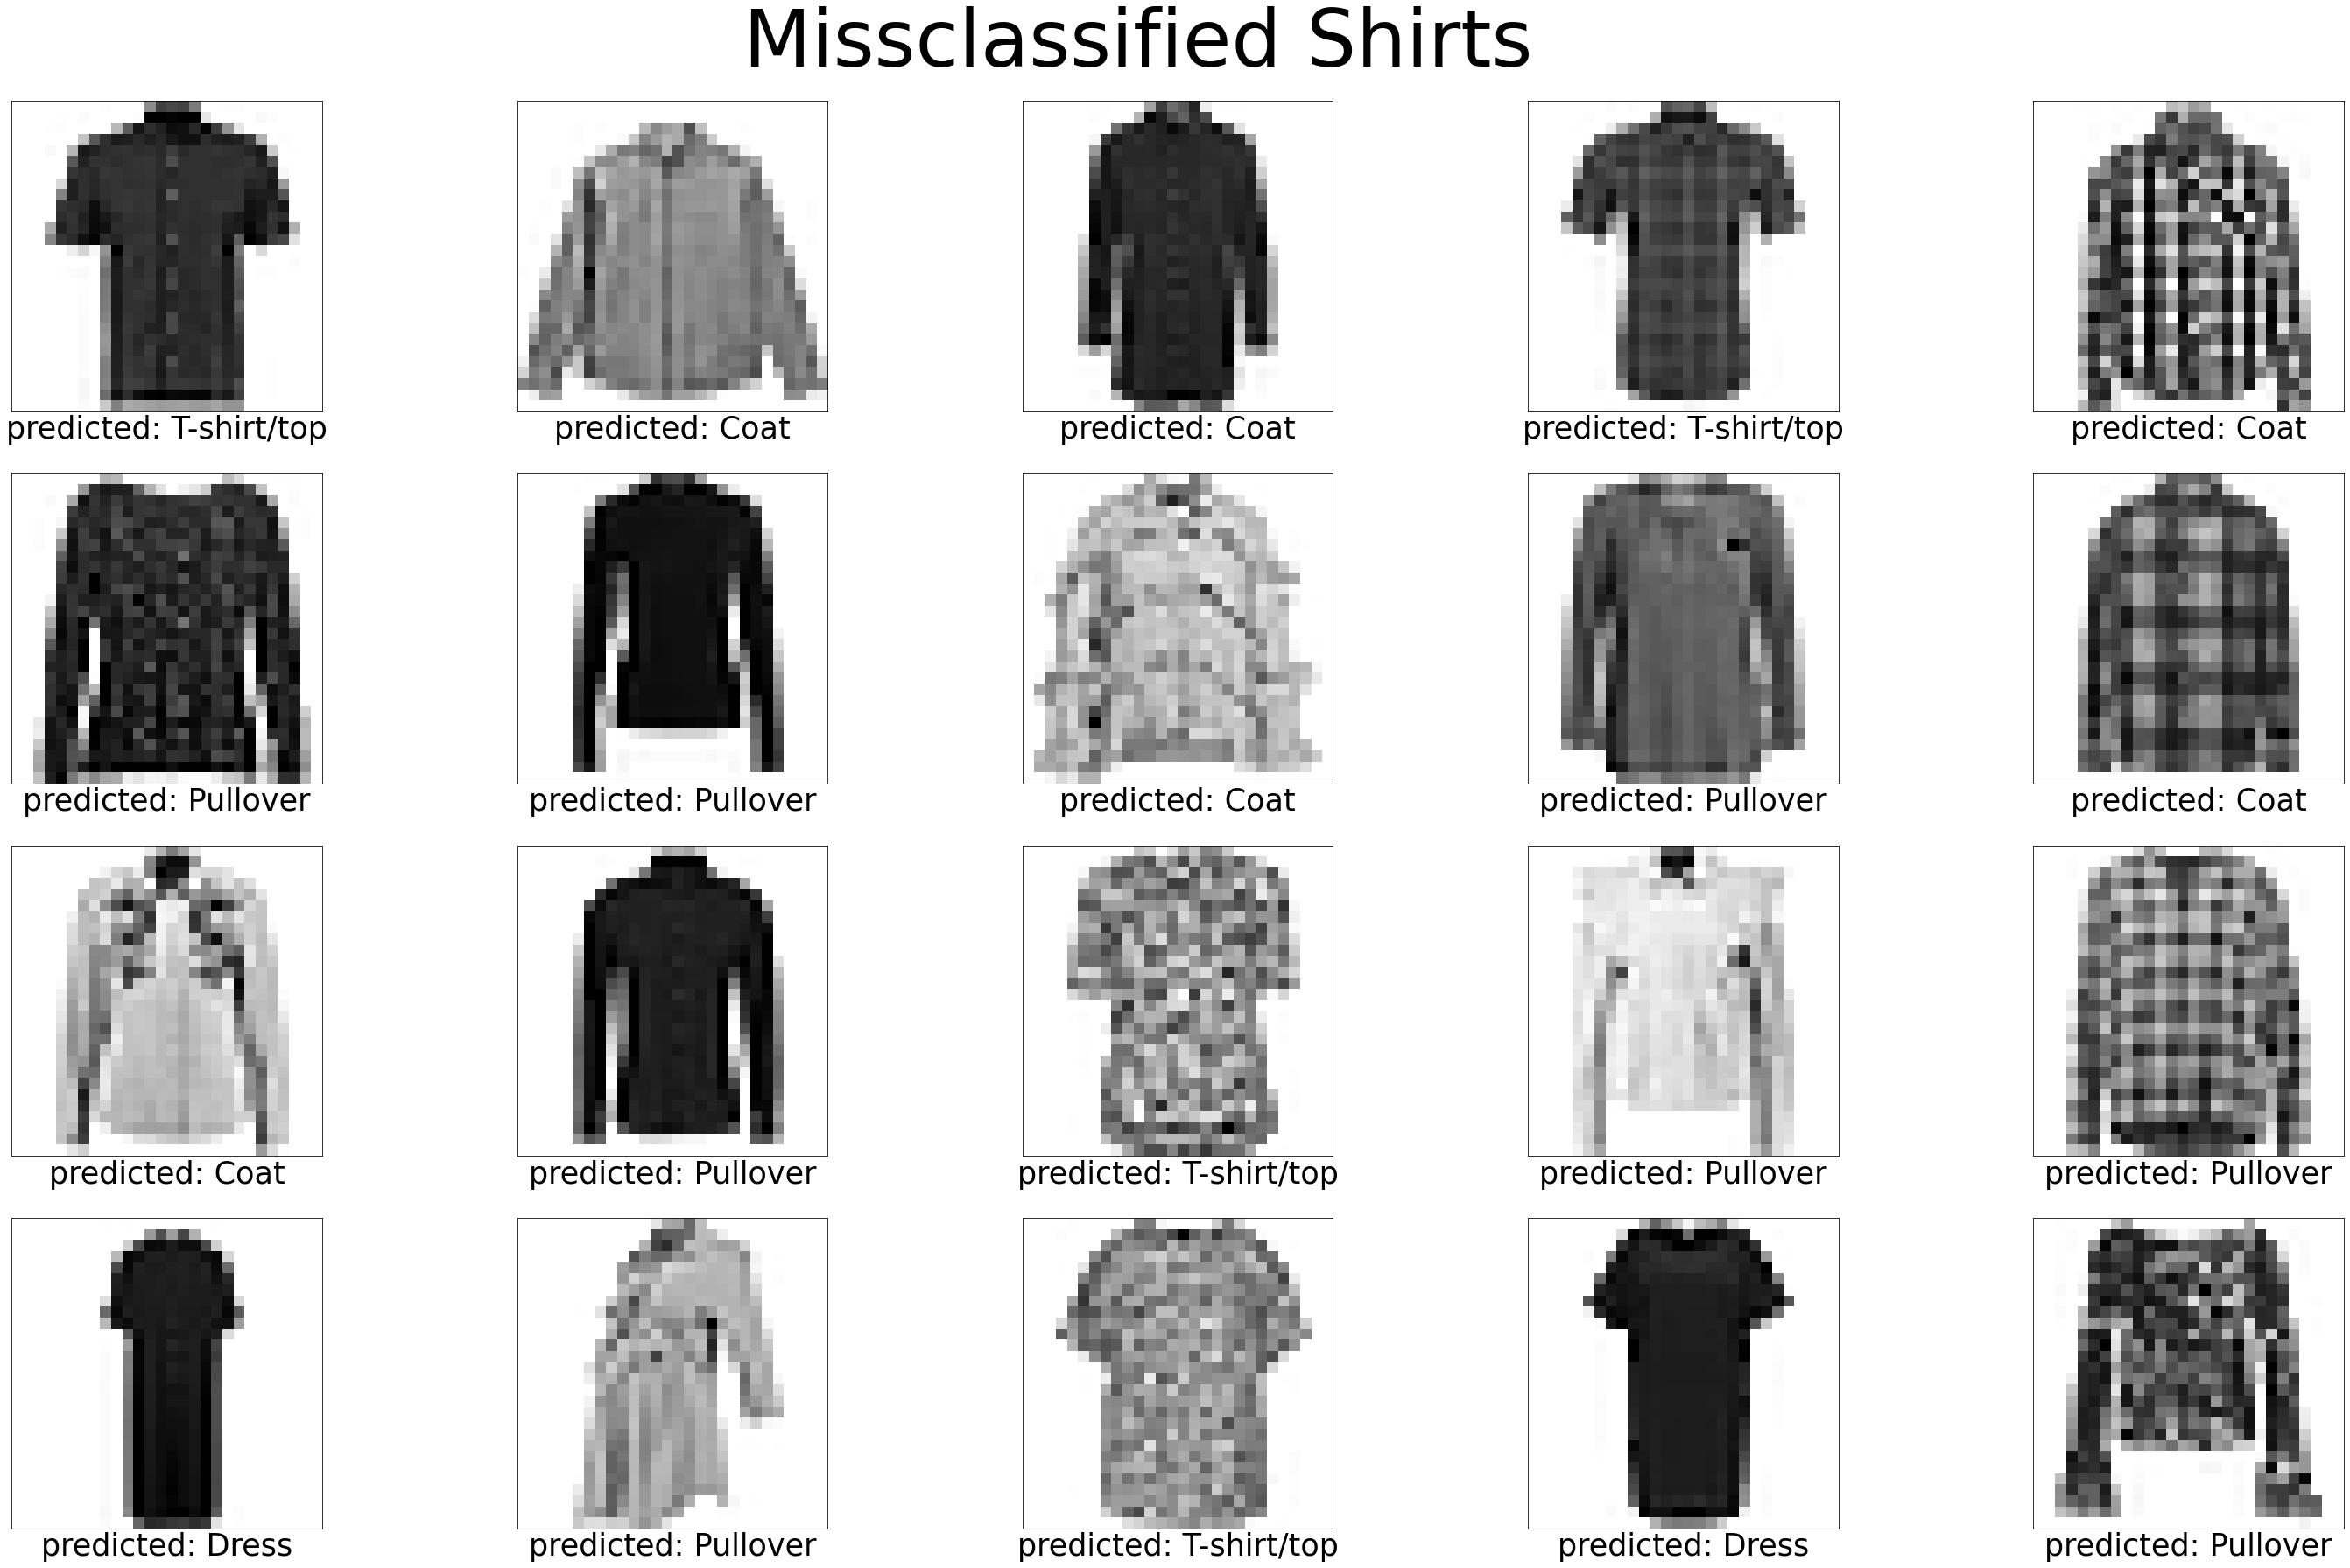

In [ ]:
n = 20
fig, axes = plt.subplots(4, 5, figsize=(50, 30))
k = 0
for i in range(len(y_pred_mlp_test)):
  if test_labels[i] == 6 and y_pred_mlp_test[i] != 6:
    ax = axes[int(k%4), int(k/4)]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test_images[i,:,:,0], cmap=plt.cm.binary)
    ax.set_xlabel('predicted: ' + get_label(y_pred_mlp_test[i]), fontsize = 35)
    k += 1
  if k == n:
    break
plt.suptitle("Missclassified Shirts", y = 0.93, fontsize = 90)
plt.show()

## CNN

In [ ]:
def cnn_model(hp):

  input = Input(shape = (image_size, image_size, 1),
                name = "Input")
  x = input

  hp_layers = hp.Int('n_layers', min_value = 1, max_value = 3)

  for i in range(hp_layers):

    if i == 0:
      hp_filters = hp.Choice(f'filters', [8, 16])
      hp_rate = hp.Choice(f'rate', [0.1, 0.2])

    x = Conv2D(filters = hp_filters*2**i,
               kernel_size = (3,3),
               strides = (1,1),
               padding = 'same',
               activation = 'relu',
               name = f"Convolution-{i+1}")(x)

    x = BatchNormalization(name = f"Normalization-{i+1}")(x)

    x = MaxPool2D(pool_size = (2, 2),
                  strides = (2, 2),
                  padding = 'same',
                  name = f"Pooling-{i+1}")(x)

    x = Dropout(rate = hp_rate,
                name = f"Dropout-{i+1}")(x)

  x = Flatten(name = "Flatten")(x)

  output = Dense(units = 10,
                 activation = 'softmax',
                 name = "Output")(x)

  model_cnn = Model(inputs=input, outputs=output)
  hp_lr = hp.Choice('learning_rate', [1e-2, 1e-3])
  model_cnn.compile(optimizer=SGD(learning_rate = hp_lr, momentum = 0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

  return model_cnn

In [ ]:
tuner = kt.BayesianOptimization(hypermodel = cnn_model,
                                objective = "val_accuracy",
                                max_trials = 6,
                                num_initial_points = 50,
                                alpha = 0.0001,
                                overwrite = True,
                                beta = 2.6,
                                seed = 1996,
                                directory="drive/MyDrive/my_dir",
                                project_name="cnn_mnist")

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16], 'ordered': True}
rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [ ]:
# perform early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, min_delta = 0.005)


In [ ]:
# perform scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

sched = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# perform the tuning
tuner.search(train_images,
             y_train,
             epochs=30,
             validation_data = (val_images, y_val),
             callbacks=[es, sched],
             batch_size=512)


Trial 6 Complete [00h 14m 34s]
val_accuracy: 0.8865000009536743

Best val_accuracy So Far: 0.9079999923706055
Total elapsed time: 01h 07m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in drive/MyDrive/my_dir/cnn_mnist
Showing 10 best trials
Trial summary
Hyperparameters:
n_layers: 3
filters: 16
rate: 0.1
learning_rate: 0.01
Score: 0.9079999923706055
Trial summary
Hyperparameters:
n_layers: 1
filters: 16
rate: 0.2
learning_rate: 0.01
Score: 0.9053333401679993
Trial summary
Hyperparameters:
n_layers: 2
filters: 16
rate: 0.2
learning_rate: 0.01
Score: 0.9035000205039978
Trial summary
Hyperparameters:
n_layers: 2
filters: 8
rate: 0.1
learning_rate: 0.01
Score: 0.9014999866485596
Trial summary
Hyperparameters:
n_layers: 3
filters: 16
rate: 0.1
learning_rate: 0.001
Score: 0.8865000009536743
Trial summary
Hyperparameters:
n_layers: 2
filters: 16
rate: 0.2
learning_rate: 0.001
Score: 0.8856666684150696


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Convolution-1 (Conv2D)      (None, 28, 28, 16)        160       
                                                                 
 Normalization-1 (BatchNorma  (None, 28, 28, 16)       64        
 lization)                                                       
                                                                 
 Pooling-1 (MaxPooling2D)    (None, 14, 14, 16)        0         
                                                                 
 Dropout-1 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 Convolution-2 (Conv2D)      (None, 14, 14, 32)        4640      
                                                           

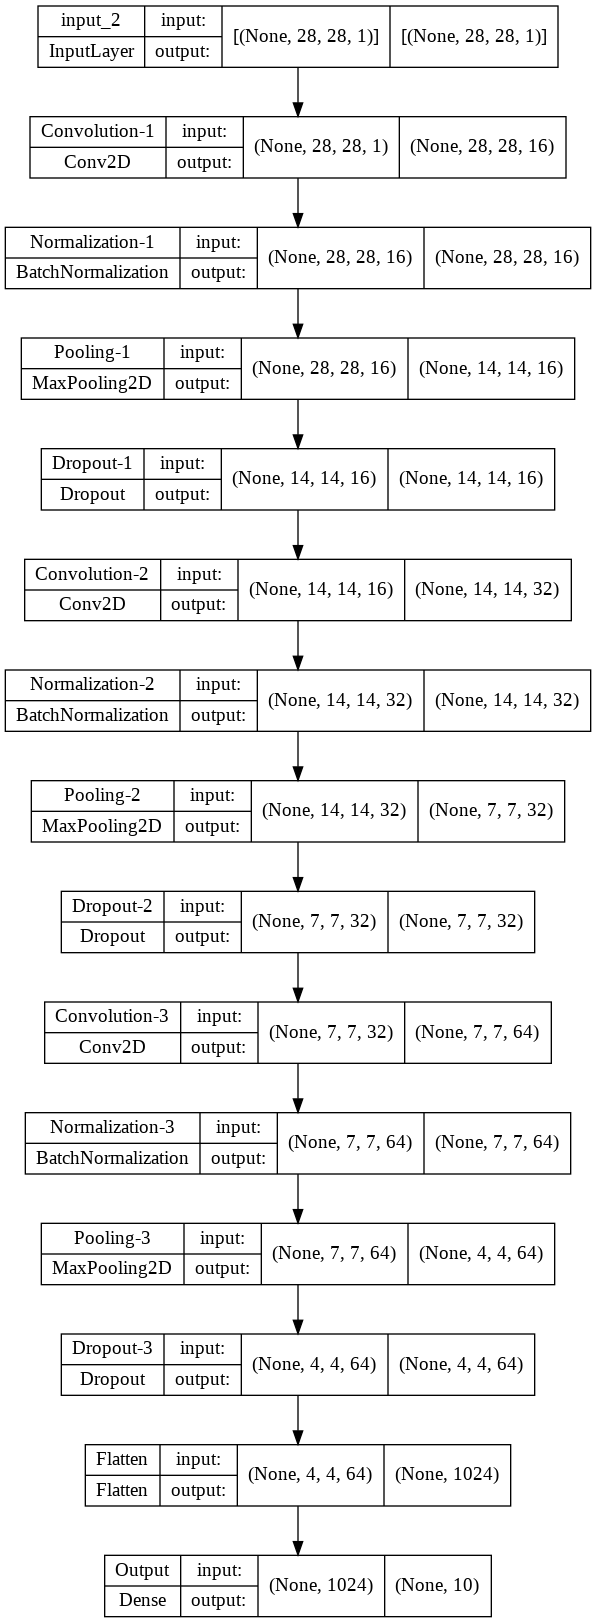

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# get the best model
model_cnn = tuner.hypermodel.build(best_hps)

model_cnn.summary()


In [ ]:
# perform early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# perform scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

sched = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Save model weights after each epoch with ModelCheckpoint
if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
  os.makedirs('/content/gdrive/My Drive/checkpoints')

checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/cnn.hdf5',
                              monitor='val_accuracy',
                              mode='max', verbose=1,
                              save_best_only=True,
                              save_weights_only=True)

In [ ]:
history = model_cnn.fit(train_images,
                        y_train,
                        validation_split = (val_images, y_val),
                        epochs = 100,
                        callbacks = [es, checkpoint, sched],
                        batch_size = 128)

Epoch 1/100
422/422 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.8183
Epoch 1: val_accuracy improved from -inf to 0.80233, saving model to /content/gdrive/My Drive/checkpoints/cnn.hdf5
422/422 [==============================] - 59s 138ms/step - loss: 0.5277 - accuracy: 0.8183 - val_loss: 0.5313 - val_accuracy: 0.8023 - lr: 0.0100
Epoch 2/100
422/422 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8745
Epoch 2: val_accuracy improved from 0.80233 to 0.89167, saving model to /content/gdrive/My Drive/checkpoints/cnn.hdf5
422/422 [==============================] - 59s 140ms/step - loss: 0.3507 - accuracy: 0.8745 - val_loss: 0.3007 - val_accuracy: 0.8917 - lr: 0.0100
Epoch 3/100
422/422 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8871
Epoch 3: val_accuracy improved from 0.89167 to 0.89517, saving model to /content/gdrive/My Drive/checkpoints/cnn.hdf5
422/422 [==============================] - 60s 142ms/step - loss

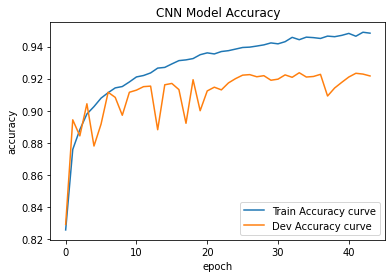

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy curve', 'Dev Accuracy curve'], loc='best')
plt.show()

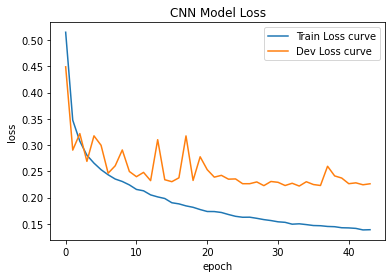

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss curve', 'Dev Loss curve'], loc='upper right')
plt.show()

In [ ]:
# save the model
model_cnn.save('/content/drive/MyDrive/cnn_pretrained', overwrite = True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/cnn_pretrained/assets


In [ ]:
pretrained_cnn = load_model('/content/drive/MyDrive/cnn_pretrained')

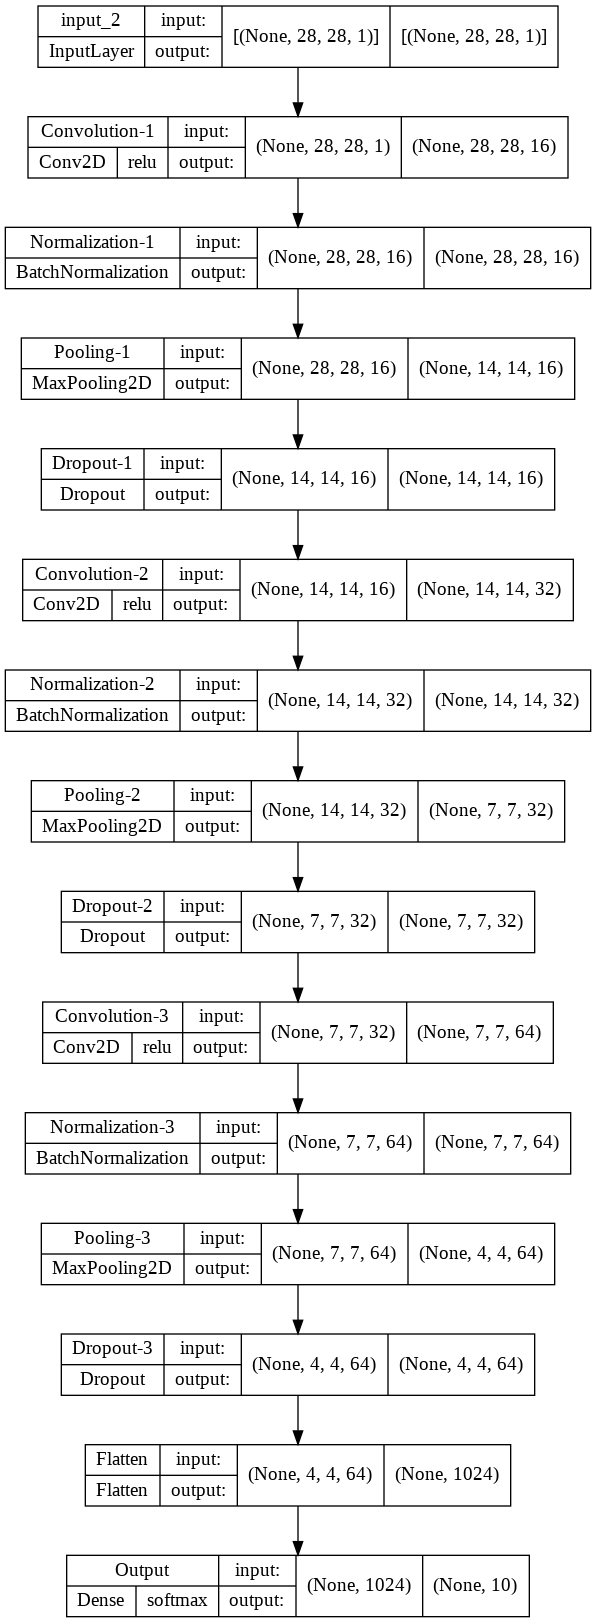

In [ ]:
plot_model(pretrained_cnn,
           to_file='cnn_plot.png',
           show_shapes=True,
           show_layer_activations = True,
           show_layer_names=True)

In [ ]:
model_cnn_eval = pretrained_cnn.evaluate(test_images, y_test, verbose=1)

313/313 [==============================] - 5s 14ms/step - loss: 0.2225 - accuracy: 0.9256


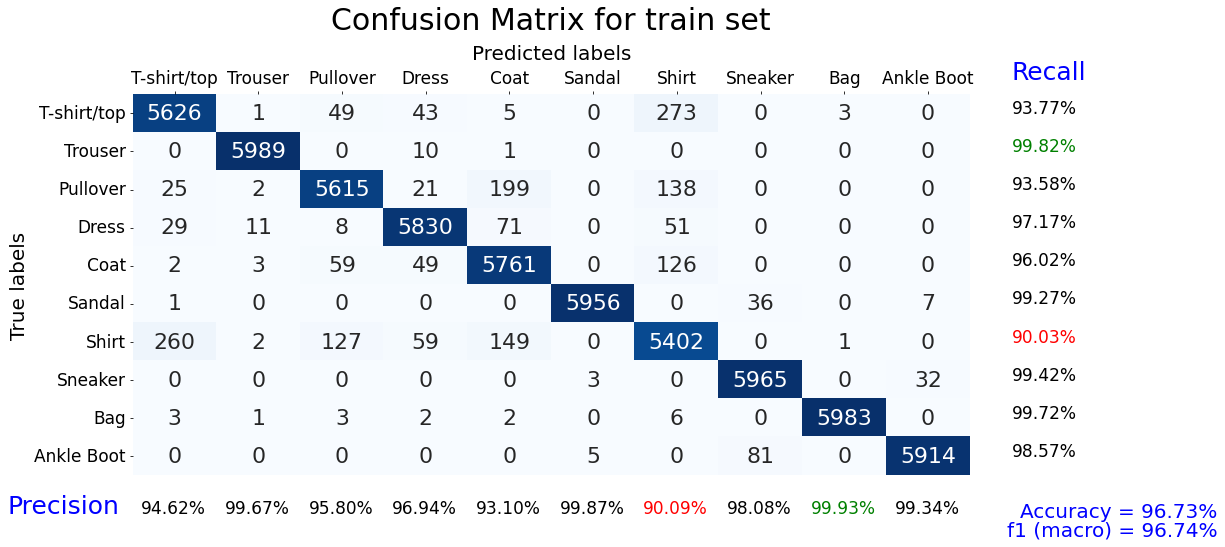

In [ ]:
predictions_prob = pretrained_cnn.predict(train_images_total)
y_pred_cnn_train = np.argmax(predictions_prob, axis = 1)
plot_confusion_matrix(train_labels, y_pred_cnn_train, title = "Confusion Matrix for train set")

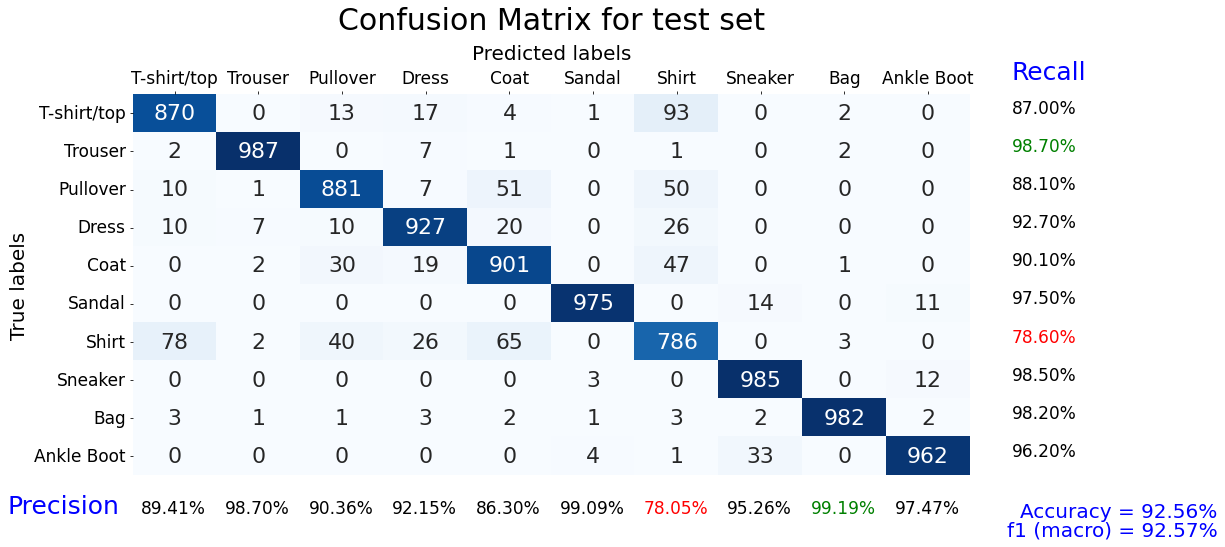

In [ ]:
predictions_prob_cnn = pretrained_cnn.predict(test_images)
y_pred_cnn_test = np.argmax(predictions_prob_cnn, axis = 1)
plot_confusion_matrix(test_labels, y_pred_cnn_test, title = "Confusion Matrix for test set")

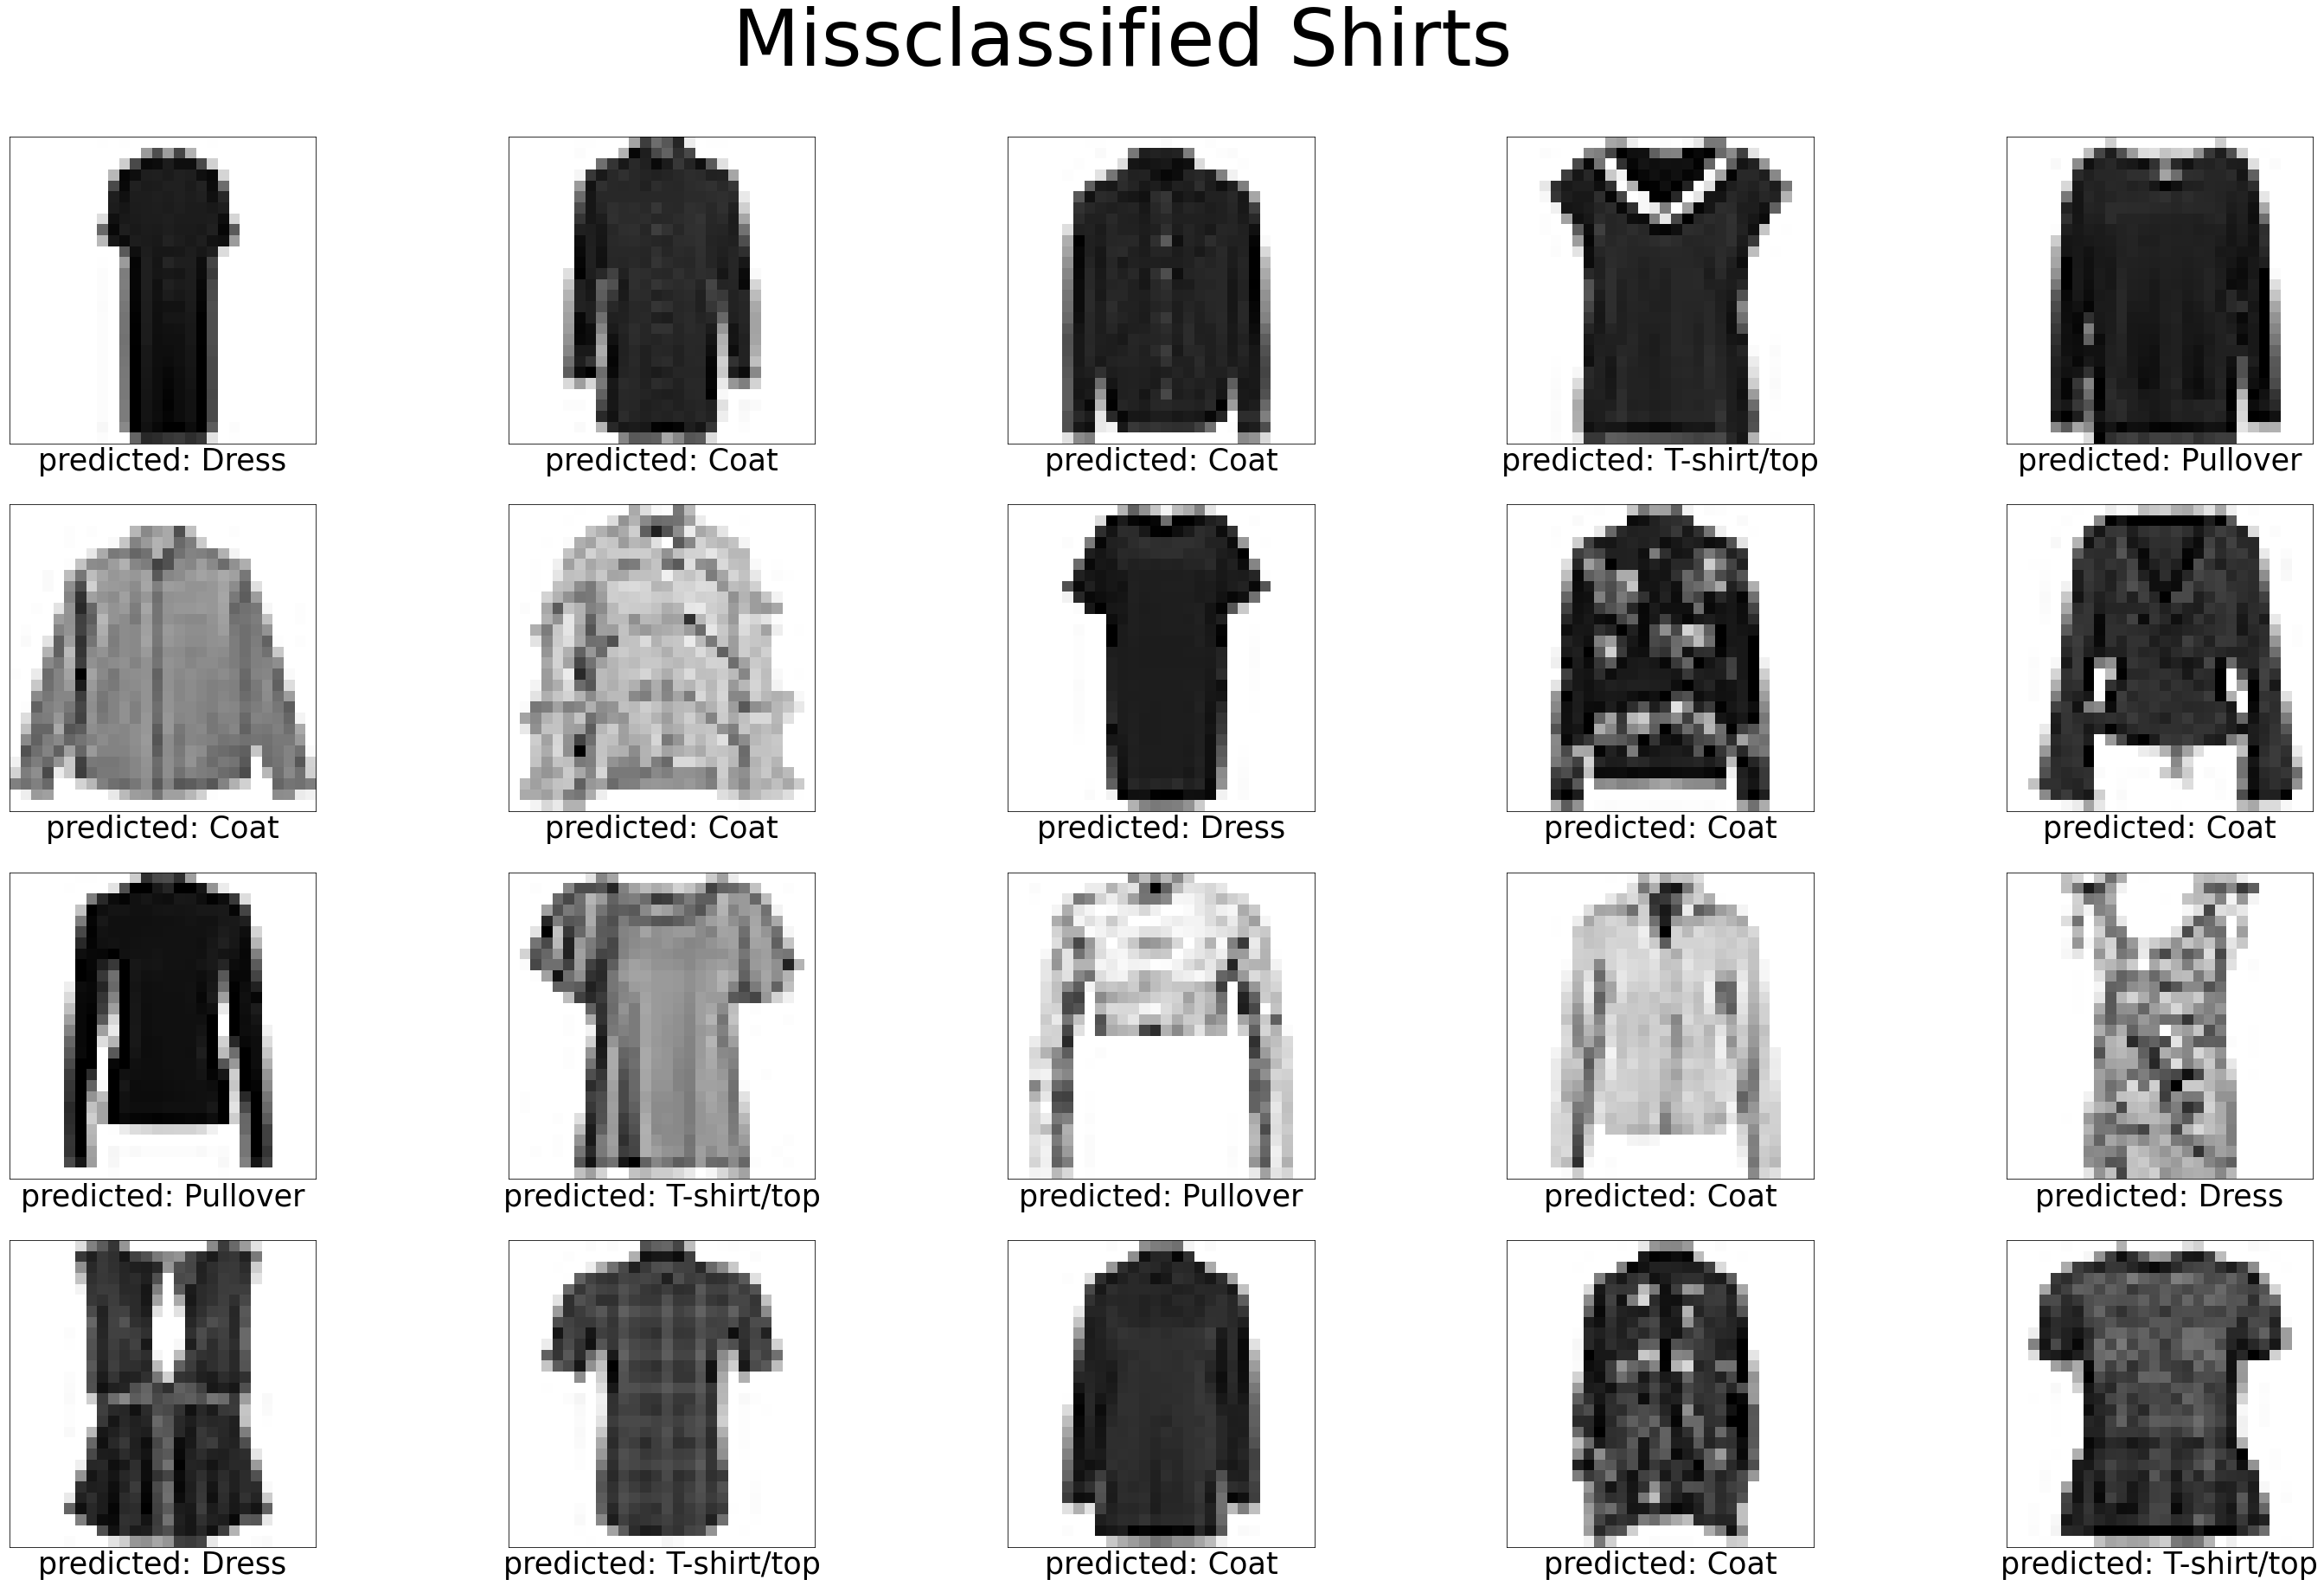

In [ ]:
n = 20
fig, axes = plt.subplots(4, 5, figsize=(50, 30))
k = 0
for i in range(len(y_pred_cnn_test)):
  if test_labels[i] == 6 and y_pred_cnn_test[i] != 6:
    ax = axes[int(k%4), int(k/4)]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test_images[i,:,:,0], cmap=plt.cm.binary)
    ax.set_xlabel('predicted: ' + get_label(y_pred_cnn_test[i]), fontsize = 35)
    k += 1
  if k == n:
    break
plt.suptitle("Missclassified Shirts", y = 0.95, fontsize = 90)
plt.show()

In [ ]:
y_pred_mlp_test[635]
y_pred_cnn_test[635]
test_labels[635]

8

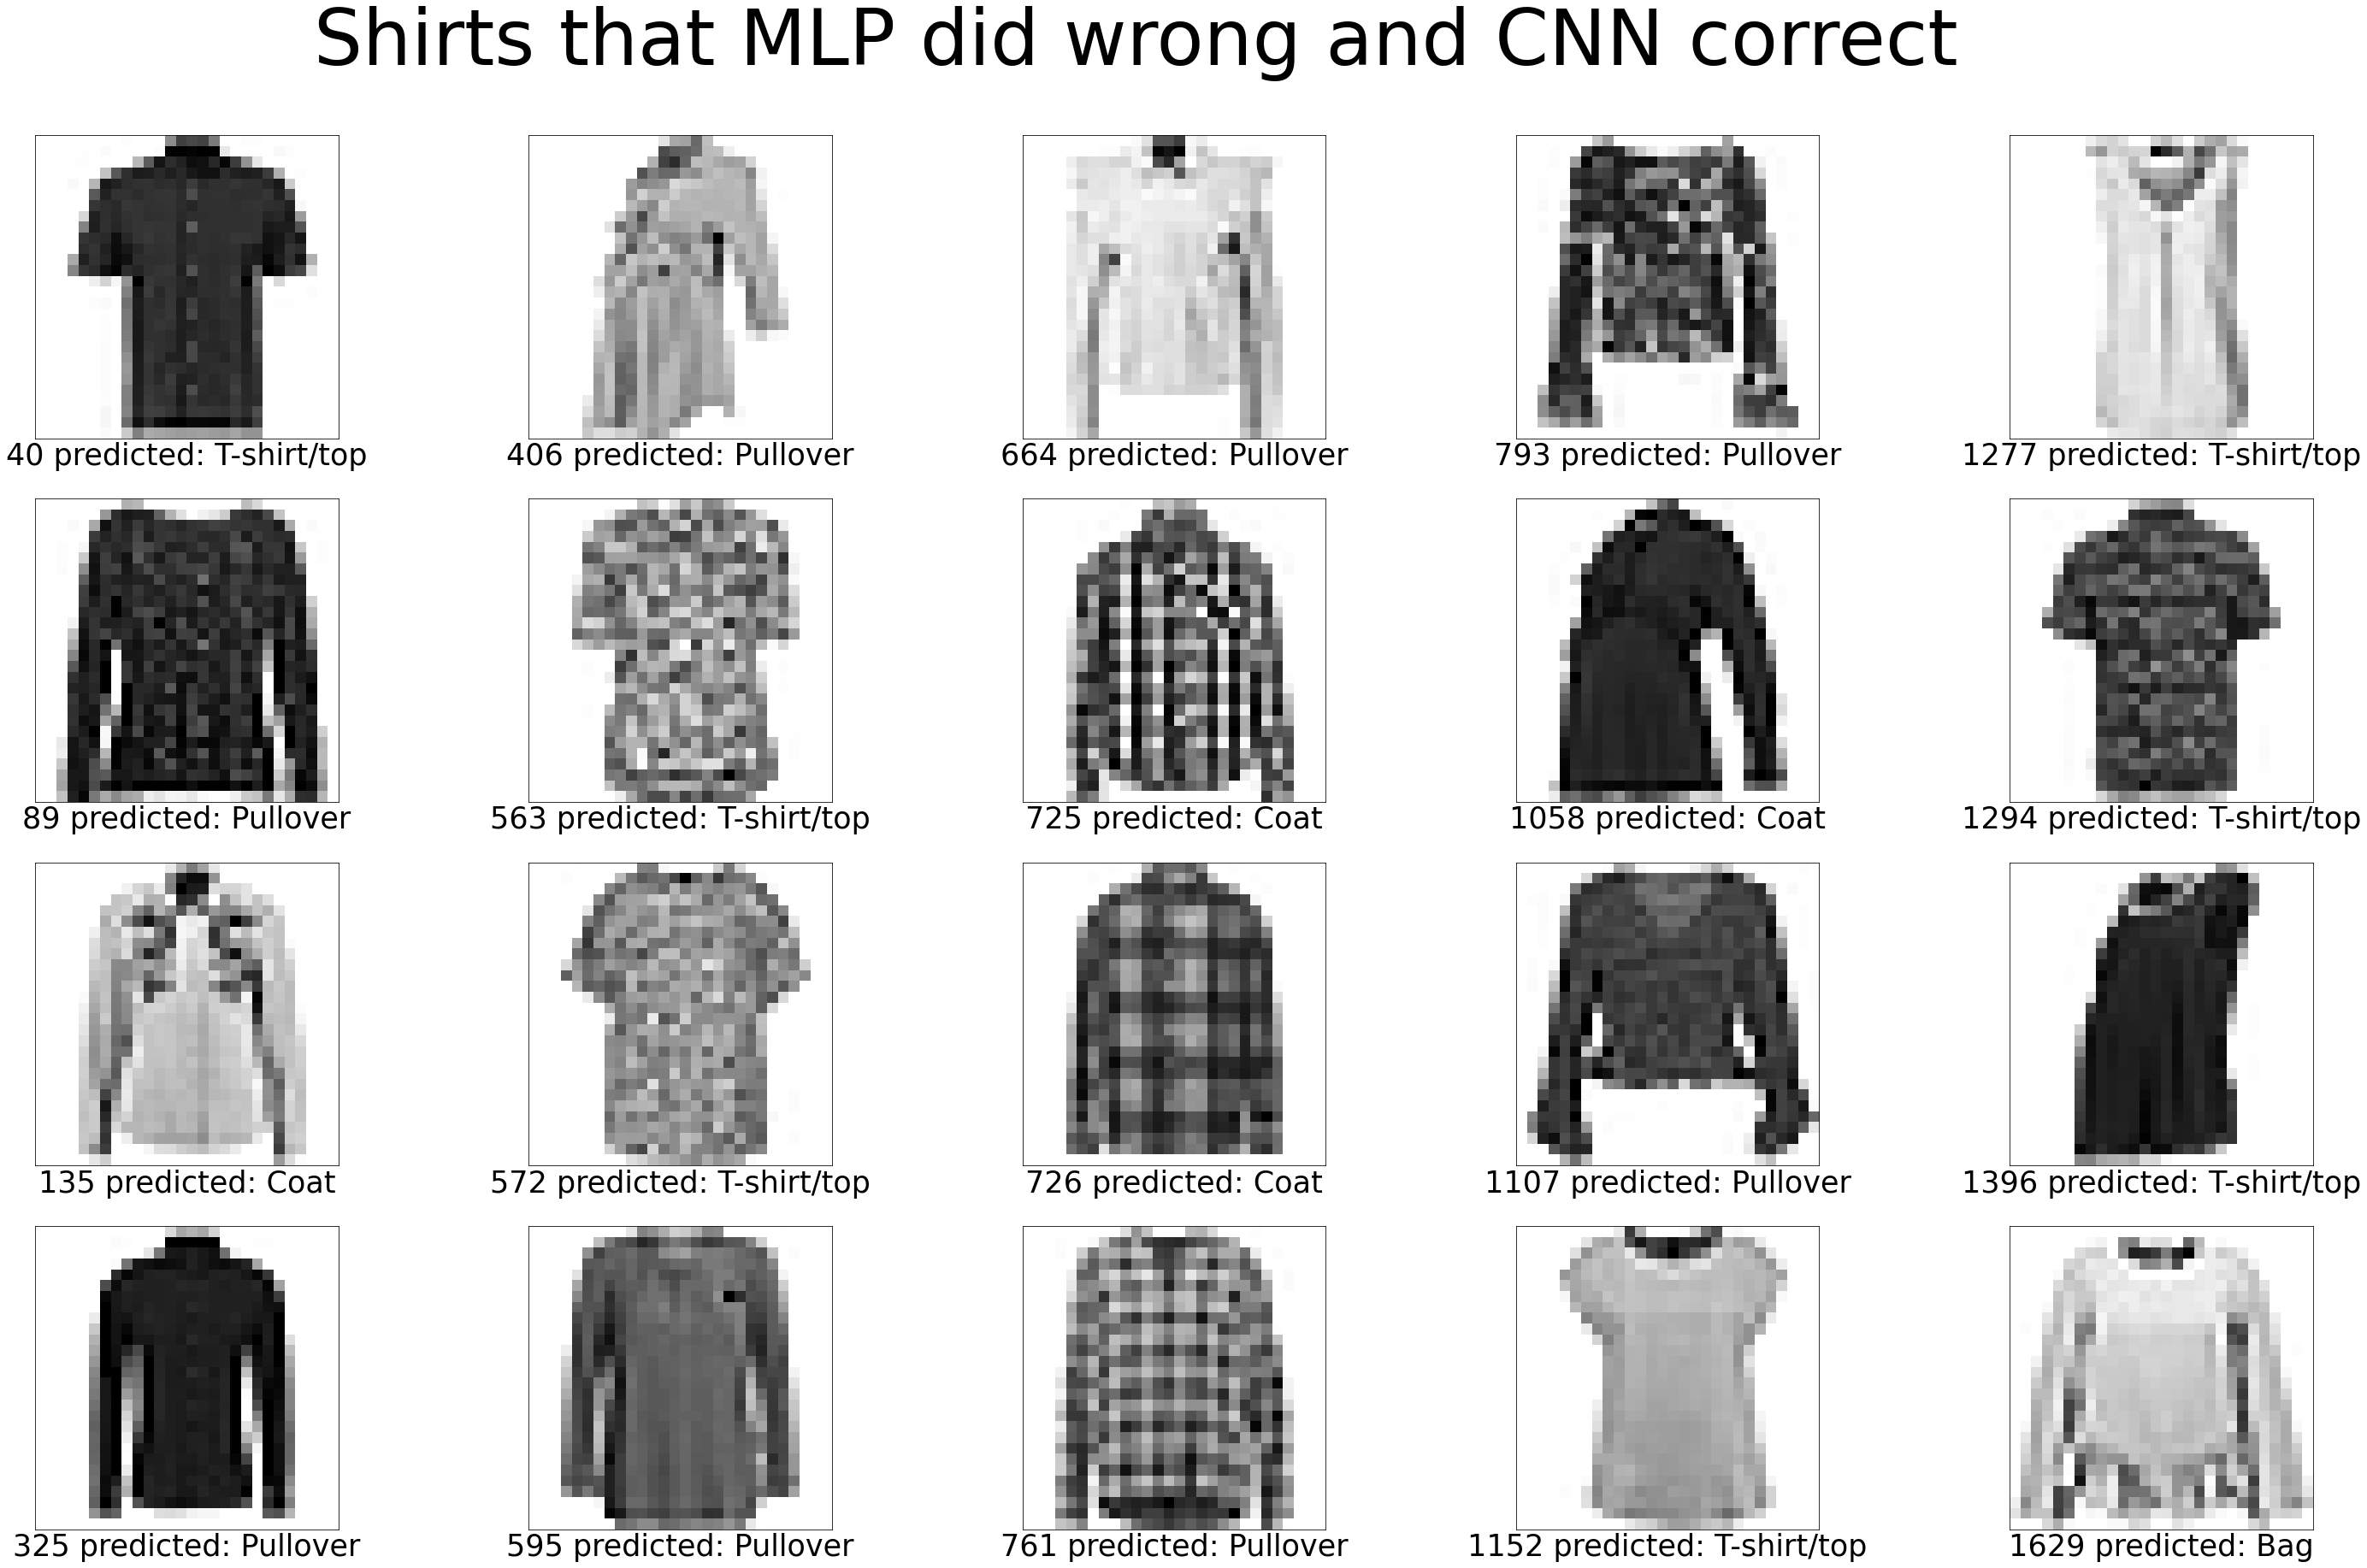

In [ ]:
n = 20
fig, axes = plt.subplots(4, 5, figsize=(50, 30))
k = 0
# display the images that cnn classified correctly, but mlp did not
for i in range(test_images_count):
  if test_labels[i] == 6 and y_pred_cnn_test[i] == 6 and y_pred_mlp_test[i] != 6:
    ax = axes[int(k%4), int(k/4)]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test_images[i,:,:,0], cmap=plt.cm.binary)
    ax.set_xlabel(str(i) + ' predicted: ' + get_label(y_pred_mlp_test[i]), fontsize = 35)
    k += 1
  if k == n:
    break
plt.suptitle("Shirts that MLP did wrong and CNN correct",
             y = 0.95,
             fontsize = 90)
plt.show()

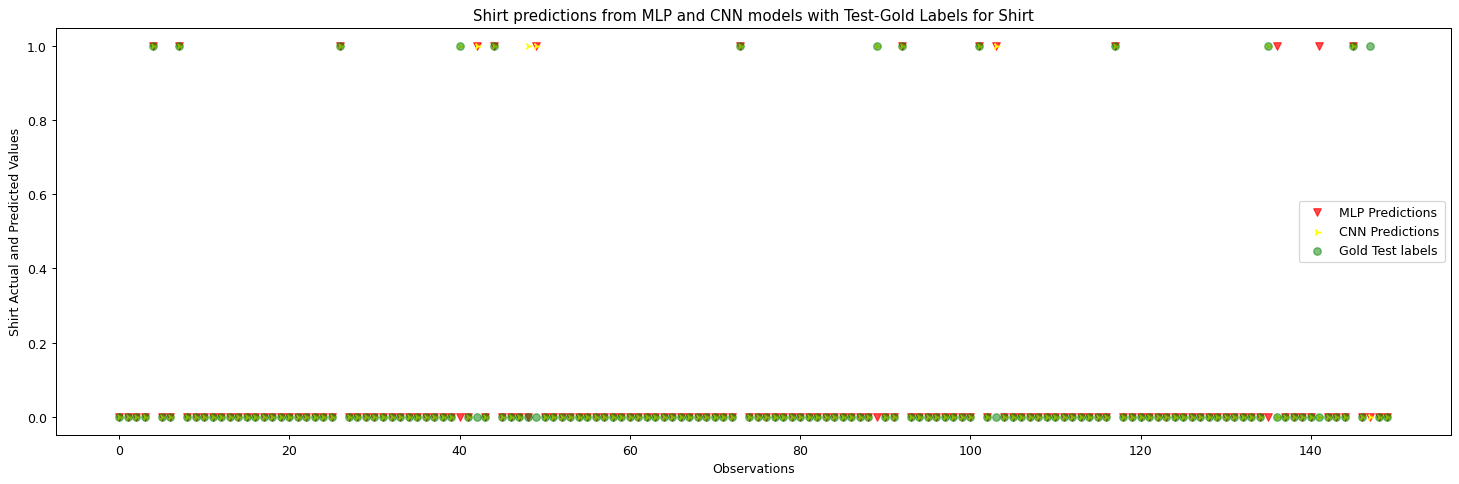

In [ ]:
y_pred_shirt_cnn = y_pred_cnn_test==6
y_pred_shirt_mlp = y_pred_mlp_test==6
test_labels_shirt = test_labels==6

k=150
plt.figure(figsize=(20, 6), dpi=90)
plt.scatter(np.arange(k),y_pred_shirt_mlp[:k],alpha=0.7,marker='v',color='r')
plt.scatter(np.arange(k),y_pred_shirt_cnn[:k],alpha= 1,marker='4',color='yellow')
plt.scatter(np.arange(k),test_labels_shirt[:k],alpha= 0.5,marker='o',color='green')
plt.title('Shirt predictions from MLP and CNN models with Test-Gold Labels for Shirt')
plt.xlabel("Observations")
plt.ylabel("Shirt Actual and Predicted Values")
plt.legend(["MLP Predictions" , "CNN Predictions","Gold Test labels"], loc='center right')
plt.show()

## Check if the combination of our Best CNN and Best MLP models leading us to higher Performance with respect to Accuracy measure

First with Kendall correlation we measure if our two models predictions differ, empirically with a measure of lower than 70% meaning that two models combination could leading us in better performance.

In [ ]:
from scipy.stats import kendalltau
corr, _ = kendalltau(y_pred_mlp_test, y_pred_cnn_test)
print('Kendall Rank correlation: %.5f' % corr)

Kendall Rank correlation: 0.88679


With almost 89% correlation we expect that the overall performance with the combination of our models probably  will not have statistical significance.However, if we had a task with inbalanced classes, and we were most interested to capture one specific class, a voting schema may were beneficial. For instance, for a problem which the subject is to predict cancer, where in most cases the classes of cancer or not cancer are inbalanced, it is obvious that a small improvement of the predictions could save lives.  Afterwards, using voting system, we are going to check that indeed the combination of the two models will not increase the performace.

In [ ]:
y_vote = np.empty(test_images_count)
for i in range(test_images_count):
  mlp_pred = np.argmax(predictions_prob_mlp, axis = 1) * np.max(predictions_prob_mlp,axis = 1)
  cnn_pred = np.argmax(predictions_prob_cnn, axis = 1) * np.max(predictions_prob_cnn,axis = 1)

  if mlp_pred[i] > cnn_pred[i]:
    y_vote[i] =  np.argmax(predictions_prob_mlp, axis = 1)[i]
  else:
    y_vote[i] =  np.argmax(predictions_prob_cnn, axis = 1)[i]

print(y_vote)

[9. 2. 1. ... 8. 1. 5.]


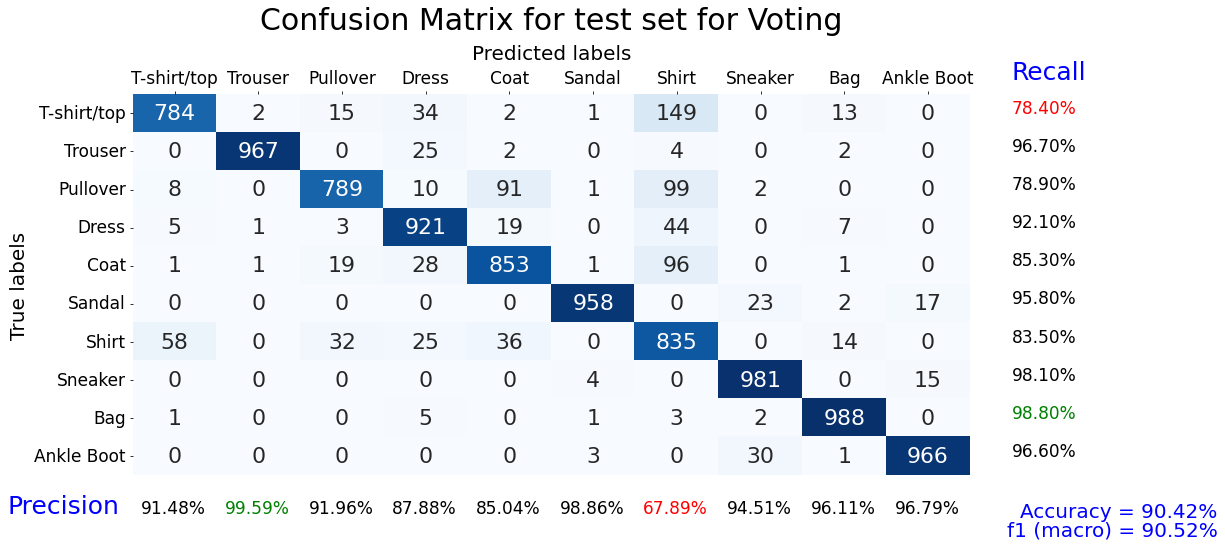

In [ ]:
plot_confusion_matrix(test_labels, y_vote, title = "Confusion Matrix for test set for Voting")